In [1]:
# Youtube: https://www.youtube.com/watch?v=NJNvXEYa_gM

In [2]:
import os, glob
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import cv2

/home/madden00/miniconda3/envs/segment/lib/python3.7/site-packages/dicom/__init__.py:53: UserWarning: 
This code is using an older version of pydicom, which is no longer 
maintained as of Jan 2017.  You can access the new pydicom features and API 
by installing `pydicom` from PyPI.
See 'Transitioning to pydicom 1.x' section at pydicom.readthedocs.org 
for more information.

  warnings.warn(msg)


In [3]:
# CONSTANTS!!!

# STEP 1 - Load and visualize data
dataInputPath = 'data/volumes/'
imagePathInput = os.path.join(dataInputPath, 'img/')
maskPathInput = os.path.join(dataInputPath, 'mask/')

dataOutputPath = 'data/slices/'
imageSliceOutput = os.path.join(dataOutputPath, 'img/')
maskSliceOutput = os.path.join(dataOutputPath, 'mask/')

# STEP 2 - Image normalization
HOUNSFIELD_MIN = -1000
HOUNSFIELD_MAX = 2000
HOUNSFIELD_RANGE = HOUNSFIELD_MAX - HOUNSFIELD_MIN

# STEP 3 - Slicing and saving
SLICE_X = True
SLICE_Y = True
SLICE_Z = False

SLICE_DECIMATE_IDENTIFIER = 3

In [4]:
# Load image and see max min Hounsfield units
imgPath = os.path.join(imagePathInput, 'tooth1.nii')
img = nib.load(imgPath).get_fdata()
np.min(img), np.max(img), img.shape, type(img)

(-933.0, 2070.0, (45, 45, 90), numpy.memmap)

In [5]:
# Load image mask and see max min Hounsfield units
maskPath = os.path.join(maskPathInput, 'tooth1.nii')
mask = nib.load(maskPath).get_fdata()
np.min(mask), np.max(mask), mask.shape, type(mask)

(0.0, 1.0, (45, 45, 90), numpy.memmap)

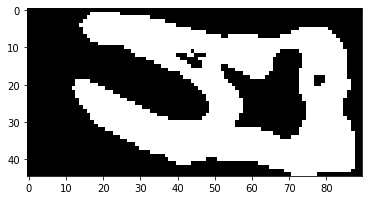

In [6]:
# Show image slice
imgSlice = mask[20,:,:]
plt.imshow(imgSlice, cmap='gray')
plt.show()

In [7]:
# Normalize image
def normalizeImageIntensityRange(img):
    img[img < HOUNSFIELD_MIN] = HOUNSFIELD_MIN
    img[img > HOUNSFIELD_MAX] = HOUNSFIELD_MAX
    return (img - HOUNSFIELD_MIN) / HOUNSFIELD_RANGE

nImg = normalizeImageIntensityRange(img)
np.min(nImg), np.max(nImg), nImg.shape, type(nImg)

(0.022333333333333334, 1.0, (45, 45, 90), numpy.ndarray)

In [8]:
# Read image or mask volume
def readImageVolume(imgPath, normalize=False):
    img = nib.load(imgPath).get_fdata()
    if normalize:
        return normalizeImageIntensityRange(img)
    else:
        return img
    
readImageVolume(imgPath, normalize=True)
readImageVolume(maskPath, normalize=False)

memmap([[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
    

In [9]:
# Save volume slice to file
def saveSlice(img, fname, path):
    img = np.uint8(img * 255)
    fout = os.path.join(path, f'{fname}.png')
    cv2.imwrite(fout, img)
    print(f'[+] Slice saved: {fout}', end='\r')
    
saveSlice(nImg[20,:,:], 'test', imageSliceOutput)
saveSlice(mask[20,:,:], 'test', maskSliceOutput)

In [10]:
# Slice image in all directions and save
def sliceAndSaveVolumeImage(vol, fname, path):
    (dimx, dimy, dimz) = vol.shape
    print(dimx, dimy, dimz)
    cnt = 0
    if SLICE_X:
        cnt += dimx
        print('Slicing X: ')
        for i in range(dimx):
            saveSlice(vol[i,:,:], fname+f'-slice{str(i).zfill(SLICE_DECIMATE_IDENTIFIER)}_x', path)
            
    if SLICE_Y:
        cnt += dimy
        print('Slicing Y: ')
        for i in range(dimy):
            saveSlice(vol[:,i,:], fname+f'-slice{str(i).zfill(SLICE_DECIMATE_IDENTIFIER)}_y', path)
            
    if SLICE_Z:
        cnt += dimz
        print('Slicing Z: ')
        for i in range(dimz):
            saveSlice(vol[:,:,i], fname+f'-slice{str(i).zfill(SLICE_DECIMATE_IDENTIFIER)}_z', path)
    return cnt

In [11]:
# Read and process image volumes
for index, filename in enumerate(sorted(glob.iglob(imagePathInput+'*.nii'))):
    img = readImageVolume(filename, True)
    print(filename, img.shape, np.sum(img.shape), np.min(img), np.max(img))
    numOfSlices = sliceAndSaveVolumeImage(img, 'tooth'+str(index), imageSliceOutput)
    print(f'\n{filename}, {numOfSlices} slices created \n')

data/volumes/img/tooth1.nii (45, 45, 90) 180 0.022333333333333334 1.0
Slicing X: 
Slicing Y: 
[+] Slice saved: data/slices/img/tooth0-slice044_y.png
data/volumes/img/tooth1.nii, 90 slices created 

data/volumes/img/tooth2.nii (45, 45, 90) 180 0.0 0.9263333333333333
Slicing X: 
Slicing Y: 
[+] Slice saved: data/slices/img/tooth1-slice044_y.png
data/volumes/img/tooth2.nii, 90 slices created 



data/volumes/img/tooth3.nii (46, 46, 92) 184 0.0 0.9866666666666667
Slicing X: 
Slicing Y: 
[+] Slice saved: data/slices/img/tooth2-slice045_y.png
data/volumes/img/tooth3.nii, 92 slices created 

data/volumes/img/tooth4.nii (44, 44, 88) 176 0.10566666666666667 1.0
Slicing X: 
Slicing Y: 
[+] Slice saved: data/slices/img/tooth3-slice043_y.png
data/volumes/img/tooth4.nii, 88 slices created 

data/volumes/img/tooth5.nii (50, 50, 100) 200 0.013666666666666667 1.0
Slicing X: 
Slicing Y: 
[+] Slice saved: data/slices/img/tooth4-slice049_y.png
data/volumes/img/tooth5.nii, 100 slices created 



In [12]:
# Read and process image mask volumes
for index, filename in enumerate(sorted(glob.iglob(maskPathInput+'*.nii'))):
    img = readImageVolume(filename, False)
    print(filename, img.shape, np.sum(img.shape), np.min(img), np.max(img))
    numOfSlices = sliceAndSaveVolumeImage(img, 'tooth'+str(index), maskSliceOutput)
    print(f'\n{filename}, {numOfSlices} slices created \n')

data/volumes/mask/tooth1.nii (45, 45, 90) 180 0.0 1.0
Slicing X: 
Slicing Y: aved: data/slices/mask/tooth0-slice044_x.png
[+] Slice saved: data/slices/mask/tooth0-slice044_y.png
data/volumes/mask/tooth1.nii, 90 slices created 

data/volumes/mask/tooth2.nii (45, 45, 90) 180 0.0 1.0
Slicing X: 
Slicing Y: aved: data/slices/mask/tooth1-slice044_x.png
[+] Slice saved: data/slices/mask/tooth1-slice044_y.png
data/volumes/mask/tooth2.nii, 90 slices created 

data/volumes/mask/tooth3.nii (46, 46, 92) 184 0.0 1.0
Slicing X: 
Slicing Y: aved: data/slices/mask/tooth2-slice045_x.png
[+] Slice saved: data/slices/mask/tooth2-slice045_y.png
data/volumes/mask/tooth3.nii, 92 slices created 

data/volumes/mask/tooth4.nii (44, 44, 88) 176 0.0 1.0
Slicing X: 
Slicing Y: aved: data/slices/mask/tooth3-slice043_x.png
[+] Slice saved: data/slices/mask/tooth3-slice043_y.png
data/volumes/mask/tooth4.nii, 88 slices created 

data/volumes/mask/tooth5.nii (50, 50, 100) 200 0.0 1.0
Slicing X: 
Slicing Y: aved: data

In [13]:
# https://github.com/madsendennis/notebooks